<a href="https://colab.research.google.com/github/AmurdAmzer/SAKT-Paper_Implementation/blob/main/SAKTPaperImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Uploading data via Colab's File Browser

In [109]:
# Cell 1: Uploading data via Colab's File Browser

# os stands for "Operating System" - it's like a special toolkit that lets your Python code talk to your computer's file system.
import os
print("Files in current directory:")
for file in os.listdir():
  if file.endswith(".csv"):
    print(f" - {file}")

Files in current directory:
 - skill_builder_data_corrected_collapsed.csv


#Cell 2: Imports and File upload

In [110]:
# Cell 2: Imports and File upload (df = pd.read_csv(....)) opens the spreadsheet(data) and puts it into a "DataFrame"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file (Remember to use the actual file name)
# encoding='ISO-8859-1' handles special characters in the data
# low_memory=False prevents dtype warnings for mixed types

# I choose to call my loaded data df, df can mean DataFrame, df is just a variable name, I can choose to name my uploaded data anything.
# low_memory=False tells the computer "take your time reading this properly, don't rush"
# encoding='ISO-8859-1' = Like telling your computer "hey, this file might have special characters like currency symbols ($ etc.)".
#  Real-Life Analogy
"""
It's like telling your computer:
When you read this file, treat these bytes or symbols as Latin-style letters — not random gibberish."

If you don't specify the correct encoding, Python might fail to read the file
"""

df = pd.read_csv('skill_builder_data_corrected_collapsed.csv', encoding='ISO-8859-1', low_memory=False)

# Show basic information about the dataset
print(f"Dataset shape: {df.shape}") # (rows, columns)
print(f"\nColumn names: {list(df.columns)}") # all column names
print(f"\nFirst 5 rows: {df.head()}") # preview first 5 rows. head() has a default parameter built in df.head(n=5). you could specify by df.head(5) etc.


Dataset shape: (346860, 31)

Column names: ['Unnamed: 0', 'order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id', 'original', 'correct', 'attempt_count', 'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time', 'template_id', 'answer_id', 'answer_text', 'first_action', 'bottom_hint', 'opportunity', 'opportunity_original']

First 5 rows:    Unnamed: 0  order_id  assignment_id  user_id  assistment_id  problem_id  \
0           1  33022537         277618    64525          33139       51424   
1           2  33022709         277618    64525          33150       51435   
2           3  35450204         220674    70363          33159       51444   
3           4  35450295         220674    70363          33110       51395   
4           5  35450311         220674    70363          33196       51481   

   original 

# Cell3: Key Statistics - Understanding the dataset size and scope

In [111]:
# Cell 3: Key Statistics - Understanding the dataset size and scope

print("===DATASET OVERVIEW===")

# Count total number of student interactions = number of rows
print(f"Toatal interactions: {len(df)}")

# Count unique students - each student has a unique user_id
print(f"Unique students: {df['user_id'].nunique()}") # df['user_id] = access the user id column. nunique = count how many unique values are in that column

# Count unique problems - individual questions students attempted
print(f"Unique problems: {df['problem_id'].nunique()}")

# Count unique skills - knowledge concepts being tested. this is crucial because I will create embeddings for each skill
print(f"Unique skills: {df['skill_id'].nunique()}")

# Calculate overall performance - percentage of correct answers
print(f"\nCorrect rate: {df['correct'].mean():.2%}")  # .2% means format the number as percentage with two decimal places, so for eg. 0.825641 becomes 82.56%

# Check data completeness for skill_id (Critical for SAKT)
# NB. SAKT needs skill_id to work - rows without the skill_id must be removed
print(f"Rows with skill_id: {df['skill_id'].notna().sum()}")
print(f"Rows missing skill_id: {df['skill_id'].isna().sum()} ({df['skill_id'].isna().mean():.1%})")


===DATASET OVERVIEW===
Toatal interactions: 346860
Unique students: 4217
Unique problems: 26688
Unique skills: 149

Correct rate: 64.53%
Rows with skill_id: 283105
Rows missing skill_id: 63755 (18.4%)


# CELL 4: Examine One Student's Learning Journey (Creating a case study).
# Before SAKT learns from all students, you want to see what one student's learning path looks like
# This helps to understand the sequential nature of the data

In [112]:
# Cell 4: Examine One Student's (random) Learning Journey
# This helps us understand the sequential nature of the data

# Find students sorted by number of attempts (most active students)
student_activity = df['user_id'].value_counts()

# Pick the 11th most active student (avoid outliers)
student_id = student_activity.index[20]

# Get all data for this student, sorted by time
# Order_id represents the sequence of attempsts

student_data = df[df['user_id'] == student_id].sort_values('order_id')

# Display student summary
print(f"Student {student_id} attempted {len(student_data)} problems")
print(f"Skills attempted: {student_data['skill_id'].nunique()}")
print(f"Correct rate: {student_data['correct'].mean():.2%}")

# Show their first 30 attempts to see the sequential Pattern
print("\nFirst 30 attempts:")
print(student_data[['order_id', 'skill_id', 'correct', 'ms_first_response']].head(30))

Student 96235 attempted 977 problems
Skills attempted: 87
Correct rate: 58.03%

First 30 attempts:
        order_id skill_id  correct  ms_first_response
96959   38171250       49        0               6228
96960   38171251       49        1               4544
96961   38171252       49        1               6059
96962   38171253       49        0               6154
96963   38171254       49        0              11896
96964   38171255       49        1              11180
96965   38171256       49        0               5603
96966   38171257       49        0               5152
96967   38171258       49        0               8184
96968   38171259       49        0               3551
96969   38171260       49        1               7122
96970   38171261       49        1               4576
96971   38171262       49        0               4139
96972   38171263       49        0               6022
96973   38171264       49        0              14956
96974   38171265       49        1   

# CELL 5: Visualize Key Patterns to Understand The Data Better

In [113]:
# CELL 5: Visualing Key Patterns to Understand the Data Better

# Calculate seuence length for each student (how many problems/quenstions/skills did each student attempt)

seq_lengths = df.groupby('user_id').size()

# seq_len for the Top 20 students
print("top 20 Most Active Students:")
print("user_id: sequence length")
sorted_seq = seq_lengths.sort_values(ascending=False)
for user_id, length in sorted_seq.head(20).items():
  print(f"{user_id}:     {length}")

print("\n")


# seq_len for the Buttom 20 students
print("Buttom 20 Least Active Students:")
print("user_id: sequence length")
sorted_seq = seq_lengths.sort_values(ascending=False)
for user_id, length in sorted_seq.tail(20).items():
  print(f"{user_id}:     {length}")

print("\n")

# Random 20 students sorted by length
print("20 Random students sorted by length")
print("user_id: sequence length")
random_sample = seq_lengths.sample(20).sort_values() # If you remove the ascending argument, pandas uses the default, which is: ascending=True
for user_id, length in random_sample.items():
  print(f"{user_id}:     {length}")





top 20 Most Active Students:
user_id: sequence length
78978:     1383
78970:     1334
79032:     1264
79021:     1239
96274:     1236
78979:     1163
96244:     1149
75169:     1129
79013:     1124
78989:     1115
79029:     1112
78980:     1112
79019:     1095
71881:     1089
78987:     1084
96243:     1083
79031:     1064
79018:     1041
96265:     1014
79012:     1005


Buttom 20 Least Active Students:
user_id: sequence length
87330:     1
87336:     1
87337:     1
91464:     1
91439:     1
87376:     1
92527:     1
85549:     1
85553:     1
85554:     1
85555:     1
85556:     1
85558:     1
85367:     1
77725:     1
74701:     1
71163:     1
84309:     1
51933:     1
84305:     1


20 Random students sorted by length
user_id: sequence length
84095:     4
87270:     5
87540:     5
91870:     5
84085:     5
87417:     6
84964:     7
91124:     10
87066:     10
78406:     12
86420:     16
82934:     20
84686:     21
78051:     57
78998:     70
88171:     81
80172:     114
78772:     

# CELL 6: Data Quality Check - Critical for Reliable Model Training

In [114]:
# CELL 6: Data Quality Check - Critical for Reliable Model Training

print("Data Quality Report:")
print("-" * 40)

# Check 1: Duplicate rows (same data appearing multiple times)
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("Need to remove duplicates!")

# Check 2: Students with very few attempts
# SAKT needs sufficient history to learn patterns
too_few = (seq_lengths < 5).sum()
print(f"Students with <5 attempts: {too_few} ({too_few/len(seq_lengths)*100:.1f}%)")

# Check 3: Students with too many attempts (potential outliers)
too_many = (seq_lengths > 500).sum()
print(f"Students with >500 attempts: {too_many}")

# Check 4: Temporal ordering validation
# Sort by user and order_id to check sequence integrity
df_sorted = df.sort_values(['user_id', 'order_id'])
# For each user, check if order_id always increases
is_ordered = df_sorted.groupby('user_id')['order_id'].apply(
    lambda x: (x.diff().dropna() > 0).all()  # diff() calculates difference between consecutive values
).all()
print(f"All sequences properly ordered: {is_ordered}")

# Check 5: Original vs scaffolding problems
# Original = main problem, scaffolding = hints/sub-problems
original_count = (df['original'] == 1).sum()
scaffold_count = (df['original'] == 0).sum()
print(f"\nOriginal problems: {original_count} ({original_count/len(df)*100:.1f}%)")
print(f"Scaffolding problems: {scaffold_count} ({scaffold_count/len(df)*100:.1f}%)")
print("SAKT paper uses only original problems")

# Check 6: Answer distribution
print(f"\nAnswer distribution:")
print(f"Correct: {(df['correct'] == 1).sum()} ({df['correct'].mean()*100:.1f}%)")
print(f"Incorrect: {(df['correct'] == 0).sum()} ({(1-df['correct'].mean())*100:.1f}%)")

# Check 7: Critical missing data for SAKT
print(f"\nMissing data analysis:")
print(f"Missing skill_id: {df['skill_id'].isna().sum()} rows ({df['skill_id'].isna().mean()*100:.1f}%)")
print(f"Missing user_id: {df['user_id'].isna().sum()} rows")
print(f"Missing correct: {df['correct'].isna().sum()} rows")
print("SAKT requires skill_id, user_id, and correct to be present")

Data Quality Report:
----------------------------------------
Duplicate rows: 0
Students with <5 attempts: 473 (11.2%)
Students with >500 attempts: 181
All sequences properly ordered: True

Original problems: 275458 (79.4%)
Scaffolding problems: 71402 (20.6%)
SAKT paper uses only original problems

Answer distribution:
Correct: 223818 (64.5%)
Incorrect: 123042 (35.5%)

Missing data analysis:
Missing skill_id: 63755 rows (18.4%)
Missing user_id: 0 rows
Missing correct: 0 rows
SAKT requires skill_id, user_id, and correct to be present


# CELL 7: Data Preprocessing for SAKT

In [115]:
# CELL 7: Data Preprocessing for SAKT

print("Starting data preprocessing...")
print(f"Original data shape: {df.shape}")

# Step 1: Keep only original problems (main problems, not hints)
# SAKT paper specifies using only original problems
df_clean = df[df['original'] == 1].copy()
print(f"\nAfter keeping only original problems: {df_clean.shape}")

# Step 2: Remove rows with missing skill_id
# SAKT requires skill_id to create embeddings
df_clean = df_clean.dropna(subset=['skill_id'])
print(f"After removing missing skill_id: {df_clean.shape}")

# Step 3: Convert skill_id to integer (it might be float due to NaN values)
df_clean['skill_id'] = df_clean['skill_id'].astype(int)

# Step 4: Calculate sequence lengths per student
student_seq_lengths = df_clean.groupby('user_id').size()

# Step 5: Keep only students with >= 0 attempts
# Too few attempts don't provide enough learning history
valid_students = student_seq_lengths[student_seq_lengths >= 0].index
df_clean = df_clean[df_clean['user_id'].isin(valid_students)]
print(f"After removing students with <5 attempts: {df_clean.shape}")

# Step 6: Sort by user_id and order_id (temporal order)
df_clean = df_clean.sort_values(['user_id', 'order_id'])

print(f"\nFinal clean dataset:")
print(f"- Total interactions: {len(df_clean)}")
print(f"- Unique students: {df_clean['user_id'].nunique()}")
print(f"- Unique skills: {df_clean['skill_id'].nunique()}")
print(f"- Average correct rate: {df_clean['correct'].mean():.2%}")

Starting data preprocessing...
Original data shape: (346860, 31)

After keeping only original problems: (275458, 31)
After removing missing skill_id: (259399, 31)
After removing students with <5 attempts: (259399, 31)

Final clean dataset:
- Total interactions: 259399
- Unique students: 4163
- Unique skills: 145
- Average correct rate: 65.80%


# CELL 8: Transform Data into SAKT Input Format

In [116]:
# CELL 8: Transform Data into SAKT Input Format

# Get unique skills and create mapping
unique_skills = sorted(df_clean['skill_id'].unique())
num_skills = len(unique_skills)

# Create skill_id to index mapping (0 to num_skills-1)
skill_to_idx = {skill: idx for idx, skill in enumerate(unique_skills)}

print(f"Number of unique skills: {num_skills}")
print(f"Skill IDs range: {min(unique_skills)} to {max(unique_skills)}")

# Function to create sequences for each student
def create_student_sequences(df_clean, skill_to_idx, num_skills):
    """
    Convert student interactions into SAKT format:
    - interaction = skill_idx + (correct * num_skills)
    """
    sequences = []

    # Process each student
    for user_id, user_data in df_clean.groupby('user_id'):
        # Get student's attempt history
        skills = user_data['skill_id'].values
        corrects = user_data['correct'].values

        # Convert skill_id to indices
        skill_indices = [skill_to_idx[skill] for skill in skills]

        # Create interaction sequence (SAKT encoding)
        # interaction = skill_index + (correct * num_skills)
        interactions = []
        for skill_idx, correct in zip(skill_indices, corrects):
            interaction = skill_idx + (correct * num_skills)
            interactions.append(interaction)

        sequences.append({
            'user_id': user_id,
            'skill_indices': skill_indices,
            'corrects': corrects,
            'interactions': interactions,
            'length': len(interactions)
        })

    return sequences

# Create sequences
print("\nCreating student sequences...")
sequences = create_student_sequences(df_clean, skill_to_idx, num_skills)

# Show example sequence
print(f"\nExample sequence (first student):")
example = sequences[0]
print(f"User ID: {example['user_id']}")
print(f"Sequence length: {example['length']}")
print(f"First 5 skills attempted: {example['skill_indices'][:5]}")
print(f"First 5 responses (0=wrong, 1=correct): {example['corrects'][:5]}")
print(f"First 5 interaction encodings: {example['interactions'][:5]}")

Number of unique skills: 145
Skill IDs range: 1 to 173190193221

Creating student sequences...

Example sequence (first student):
User ID: 14
Sequence length: 19
First 5 skills attempted: [132, 132, 132, 132, 132]
First 5 responses (0=wrong, 1=correct): [0 1 0 0 0]
First 5 interaction encodings: [np.int64(132), np.int64(277), np.int64(132), np.int64(132), np.int64(132)]


# CELL 9: Split Data for Training (Student-Level Split)

In [117]:
# CELL 9: Split Data for Training (Student-Level Split)

from sklearn.model_selection import train_test_split

# Split at student level (not interaction level) to prevent data leakage
# Each student's full sequence goes into either train, val, or test

# Use 80/20 split as in the paper (no separate validation)
train_sequences, test_sequences = train_test_split(
    sequences,
    test_size=0.2,
    random_state=42
)

# For hyperparameter tuning, create a small validation set from training
train_sequences, val_sequences = train_test_split(
    train_sequences,
    test_size=0.1,  # 10% of training data for validation
    random_state=42
)

print(f"Dataset splits:")
print(f"- Train: {len(train_sequences)} students")
print(f"- Val: {len(val_sequences)} students")
print(f"- Test: {len(test_sequences)} students")

# Calculate total interactions per split
train_interactions = sum(seq['length'] for seq in train_sequences)
val_interactions = sum(seq['length'] for seq in val_sequences)
test_interactions = sum(seq['length'] for seq in test_sequences)

print(f"\nTotal interactions per split:")
print(f"- Train: {train_interactions:,}")
print(f"- Val: {val_interactions:,}")
print(f"- Test: {test_interactions:,}")

# Save the processed data
import pickle

save_data = {
    'train': train_sequences,
    'val': val_sequences,
    'test': test_sequences,
    'num_skills': num_skills,
    'skill_to_idx': skill_to_idx
}

with open('sakt_preprocessed_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print("\nData preprocessing complete! Saved to 'sakt_preprocessed_data.pkl'")

Dataset splits:
- Train: 2997 students
- Val: 333 students
- Test: 833 students

Total interactions per split:
- Train: 185,361
- Val: 21,293
- Test: 52,745

Data preprocessing complete! Saved to 'sakt_preprocessed_data.pkl'


# CELL 10: SAKT Model Implementation

In [118]:
# CELL 10: SAKT Model Implementation

import torch
import torch.nn as nn
import torch.nn.functional as F #importing the functional module from PyTorch's torch.nn package, and giving it a shorter alias: F.
import math

class SAKT(nn.Module): # Class SAKT model that inherits nn.module
    def __init__(self, num_skills, embed_dim=100, num_heads=5, dropout=0.5):
        """
        SAKT Model matching the paper implementation

        Args:
            num_skills: Number of unique skills (145 in this case)
            embed_dim: Embedding dimension (paper uses 128)
            num_heads: Number of attention heads (paper uses 5)
            dropout: Dropout rate (paper uses 0.2)
        """
        super(SAKT, self).__init__()

        self.num_skills = num_skills
        self.embed_dim = embed_dim

        # Embedding layers
        # Interaction embedding: Maps (skill + correct*num_skills) to vectors
        self.interaction_embed = nn.Embedding(
            num_skills * 2 + 1,  # *2 because skill + correct*num_skills
            embed_dim,
            padding_idx=num_skills * 2
        )

        # Exercise/skill embedding: Maps skills to vectors for queries
        self.skill_embed = nn.Embedding(
            num_skills + 1,
            embed_dim,
            padding_idx=0
            )

        # Positional embedding: Adds temporal information
        self.pos_embed = nn.Embedding(1000, embed_dim)  # max sequence length 1000

        # Multi-head attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout=dropout,
            batch_first=True  # Important: batch dimension first
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),  # Paper uses 4x hidden size
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )

        # Output prediction layer
        self.pred = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, interactions, skills):
        """
        Forward pass of SAKT

        Args:
            interactions: [batch_size, seq_len] - past interactions (skill + correct*num_skills)
            skills: [batch_size, seq_len] - skills to predict performance on

        Returns:
            predictions: [batch_size, seq_len] - probability of correct answer
        """
        batch_size, seq_len = interactions.shape

        # Create position indices
        positions = torch.arange(seq_len, device=interactions.device).unsqueeze(0).expand(batch_size, -1)

        # Embed interactions (for Keys and Values in attention)
        interaction_embeds = self.interaction_embed(interactions)  # [batch, seq_len, embed_dim]

        # Embed skills (for Queries in attention)
        skill_embeds = self.skill_embed(skills)  # [batch, seq_len, embed_dim]

        # Add positional embeddings
        interaction_embeds = interaction_embeds + self.pos_embed(positions)
        skill_embeds = skill_embeds + self.pos_embed(positions)

        # Create attention mask (causal mask - can't see future)
        attn_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=interactions.device) * float('-inf'),
            diagonal=1
        )

        # Apply self-attention
        # Query: what skill we're predicting
        # Key & Value: past interaction history
        attended, _ = self.attention(
            query=skill_embeds,
            key=interaction_embeds,
            value=interaction_embeds,
            attn_mask=attn_mask,
            need_weights=False
        )

        # Residual connection and layer norm
        attended = self.layer_norm1(skill_embeds + self.dropout(attended))

        # Feed-forward network with residual
        ffn_out = self.ffn(attended)
        ffn_out = self.layer_norm2(attended + self.dropout(ffn_out))

        # Predict probability of correct answer
        pred = self.pred(ffn_out).squeeze(-1)  # [batch, seq_len]
        return torch.sigmoid(pred)

# Test the model
print("Testing SAKT model...")
model = SAKT(num_skills=145)

# Create dummy batch
batch_interactions = torch.randint(0, 290, (2, 50))  # 2 sequences, length 50
batch_skills = torch.randint(0, 145, (2, 50))

# Forward pass
output = model(batch_interactions, batch_skills)
print(f"Model output shape: {output.shape}")
print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Testing SAKT model...
Model output shape: torch.Size([2, 50])
Output range: [0.212, 0.834]
Model parameters: 265,101


# CELL 11: Create PyTorch Dataset and DataLoaders

In [119]:
# CELL 11: Create PyTorch Dataset and DataLoaders

from torch.utils.data import Dataset, DataLoader
import numpy as np

class SAKTDataset(Dataset):
    """Dataset class for SAKT - Corrected version"""

    def __init__(self, sequences, max_seq_len=100, num_skills=145):
        self.max_seq_len = max_seq_len
        self.num_skills = num_skills
        self.padding_interaction = num_skills * 2  # Padding token

        # Process sequences: split long ones
        self.data = []
        for seq in sequences:
            interactions = seq['interactions']
            skills = seq['skill_indices']
            corrects = seq['corrects']

            # If sequence is longer than max_seq_len, split it
            if len(interactions) > max_seq_len:
                for i in range(0, len(interactions), max_seq_len):
                    end_idx = min(i + max_seq_len, len(interactions))
                    self.data.append({
                        'interactions': interactions[i:end_idx],
                        'skills': skills[i:end_idx],
                        'corrects': corrects[i:end_idx]
                    })
            else:
                self.data.append({
                    'interactions': interactions,
                    'skills': skills,
                    'corrects': corrects
                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        seq_len = len(seq['interactions'])

        interactions = list(seq['interactions'])
        skills = list(seq['skills'])
        corrects = list(seq['corrects'])

        shifted_interactions = []
        for i in range(seq_len):
            if i == 0:
                # First position: use a special START token (same as padding)
                shifted_interactions.append(self.padding_interaction)
            else:
                # Use the PREVIOUS interaction
                shifted_interactions.append(interactions[i-1])

        # Use shifted_interactions instead of interactions
        interactions = shifted_interactions

        # Pad to the LEFT if sequence is shorter than max_seq_len
        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len

            # Pad to the LEFT
            interactions = [self.padding_interaction] * pad_len + interactions
            skills = [0] * pad_len + skills  # 0 for padding
            corrects = [0] * pad_len + corrects

            # Create mask (0 for padding, 1 for real data)
            mask = [0] * pad_len + [1] * seq_len
        else:
            mask = [1] * self.max_seq_len

        return {
            'interactions': torch.tensor(interactions, dtype=torch.long),
            'skills': torch.tensor(skills, dtype=torch.long),
            'targets': torch.tensor(corrects, dtype=torch.float),
            'mask': torch.tensor(mask, dtype=torch.float)
        }

# Load preprocessed data
import pickle
with open('sakt_preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Create datasets
train_dataset = SAKTDataset(data['train'], max_seq_len=100, num_skills=data['num_skills'])
val_dataset = SAKTDataset(data['val'], max_seq_len=100, num_skills=data['num_skills'])
test_dataset = SAKTDataset(data['test'], max_seq_len=100, num_skills=data['num_skills'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test dataloader
batch = next(iter(train_loader))
print(f"Batch keys: {batch.keys()}")
print(f"Interactions shape: {batch['interactions'].shape}")
print(f"Skills shape: {batch['skills'].shape}")
print(f"Targets shape: {batch['targets'].shape}")
print(f"Mask shape: {batch['mask'].shape}")

Batch keys: dict_keys(['interactions', 'skills', 'targets', 'mask'])
Interactions shape: torch.Size([64, 100])
Skills shape: torch.Size([64, 100])
Targets shape: torch.Size([64, 100])
Mask shape: torch.Size([64, 100])


# CELL 12: Test Data Loaders and Verify Data Format

In [120]:
# CELL 12: Test Data Loaders and Verify Data Format

import pickle

# Load the preprocessed data we saved in Cell 9
# 'rb' means read in binary mode (pickle files are binary)
with open('sakt_preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)  # Converts file back to Python dictionary

print(f"Loaded data with {data['num_skills']} unique skills")

# Create PyTorch datasets from the sequences
# SAKTDataset handles padding and creating input/target pairs
train_dataset = SAKTDataset(data['train'], max_seq_len=100)
val_dataset = SAKTDataset(data['val'], max_seq_len=100)
test_dataset = SAKTDataset(data['test'], max_seq_len=100)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)} students")
print(f"Val: {len(val_dataset)} students")
print(f"Test: {len(test_dataset)} students")

# Create data loaders that will feed batches to my model
# batch_size=64 means process 64 students at once
# shuffle=True randomizes order each epoch (important for training)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test by loading one batch to verify everything works
print(f"\nTesting data loader with one batch:")
batch = next(iter(train_loader))  # Get first batch

# Check what's in each batch
print(f"Batch contains: {list(batch.keys())}")
print(f"Interactions shape: {batch['interactions'].shape}")  # [64, 99]
print(f"Skills shape: {batch['skills'].shape}")              # [64, 99]
print(f"Targets shape: {batch['targets'].shape}")            # [64, 99]
print(f"Mask shape: {batch['mask'].shape}")                  # [64, 99]

# Look at one student's data to understand format
print(f"\nExample from first student in batch:")
first_seq_len = batch['mask'][0].sum().int()  # Count non-padded positions
print(f"Actual sequence length: {first_seq_len}")
print(f"First 5 interactions: {batch['interactions'][0][:5].tolist()}")
print(f"First 5 skills to predict: {batch['skills'][0][:5].tolist()}")
print(f"First 5 correct/incorrect: {batch['targets'][0][:5].tolist()}")
print(f"First 5 mask values: {batch['mask'][0][:5].tolist()}")  # 1=real, 0=padding

Loaded data with 145 unique skills

Dataset sizes:
Train: 4075 students
Val: 459 students
Test: 1134 students

Testing data loader with one batch:
Batch contains: ['interactions', 'skills', 'targets', 'mask']
Interactions shape: torch.Size([64, 100])
Skills shape: torch.Size([64, 100])
Targets shape: torch.Size([64, 100])
Mask shape: torch.Size([64, 100])

Example from first student in batch:
Actual sequence length: 7
First 5 interactions: [290, 290, 290, 290, 290]
First 5 skills to predict: [0, 0, 0, 0, 0]
First 5 correct/incorrect: [0.0, 0.0, 0.0, 0.0, 0.0]
First 5 mask values: [0.0, 0.0, 0.0, 0.0, 0.0]


# CELL 13: Training Functions for SAKT

In [121]:
# CELL 13: Training Functions for SAKT

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch

    Args:
        model: SAKT model
        train_loader: DataLoader with training data
        optimizer: Adam optimizer
        criterion: BCELoss function
        device: cuda or cpu

    Returns:
        epoch_loss: Average loss for this epoch
        epoch_auc: AUC score for this epoch
    """
    model.train()  # Enable dropout and batch norm training behavior
    total_loss = 0
    all_predictions = []
    all_targets = []

    # Progress bar to track training
    pbar = tqdm(train_loader, desc='Training', leave=False)

    for batch in pbar:
        # Move all tensors to GPU if available
        interactions = batch['interactions'].to(device)
        skills = batch['skills'].to(device)
        targets = batch['targets'].to(device)
        mask = batch['mask'].to(device)

        # Clear gradients from previous batch
        optimizer.zero_grad()

        # Forward pass: get predictions from model
        predictions = model(interactions, skills)

        # Calculate loss only on non-padded positions
        # criterion returns loss for each position
        # Compute loss with masking
        loss = criterion(predictions, targets)  # This gives loss per element
        masked_loss = (loss * mask).sum() / mask.sum()  # Apply mask and average


        # Backward pass: compute gradients
        masked_loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model parameters
        optimizer.step()

        # Collect predictions for metrics
        total_loss += masked_loss.item()

        # Extract only valid (non-padded) predictions
        valid_idx = mask == 1
        valid_predictions = predictions[valid_idx].detach().cpu().numpy()
        valid_targets = targets[valid_idx].detach().cpu().numpy()

        all_predictions.extend(valid_predictions)
        all_targets.extend(valid_targets)

        # Update progress bar with current loss
        pbar.set_postfix({'loss': f'{masked_loss.item():.4f}'})

    # Calculate epoch metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_auc = roc_auc_score(all_targets, all_predictions)

    return epoch_loss, epoch_auc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model (no gradient updates)

    Args:
        model: SAKT model
        val_loader: DataLoader with validation data
        criterion: BCELoss function
        device: cuda or cpu

    Returns:
        val_loss: Average validation loss
        val_auc: Validation AUC score
    """
    model.eval()  # Disable dropout and use batch norm statistics
    total_loss = 0
    all_predictions = []
    all_targets = []

    # No gradient computation needed for validation
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating', leave=False):
            # Move to device
            interactions = batch['interactions'].to(device)
            skills = batch['skills'].to(device)
            targets = batch['targets'].to(device)
            mask = batch['mask'].to(device)

            # Get predictions
            predictions = model(interactions, skills)

            # Calculate loss
            # Compute loss with masking
            loss = criterion(predictions, targets)  # This gives loss per element
            masked_loss = (loss * mask).sum() / mask.sum()  # Apply mask and average

            # Collect for metrics
            total_loss += masked_loss.item()

            # Extract valid predictions
            valid_idx = mask == 1
            valid_predictions = predictions[valid_idx].cpu().numpy()
            valid_targets = targets[valid_idx].cpu().numpy()

            all_predictions.extend(valid_predictions)
            all_targets.extend(valid_targets)

    # Calculate validation metrics
    val_loss = total_loss / len(val_loader)
    val_auc = roc_auc_score(all_targets, all_predictions)

    return val_loss, val_auc

# CELL 14: Train SAKT Model

In [122]:
# CELL 14: Train SAKT Model

# Check if GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Initialize model with paper's hyperparameters
model = SAKT(
    num_skills=145,  # From my dataset analysis
    embed_dim=100,   # Paper: d=[50, 100, 150, 200]
    num_heads=5,     # Paper: h=5
    dropout=0.5      # Paper: dropout=0.2
).to(device)

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Initialize optimizer (Adam with paper's learning rate)
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,           # Paper uses 0.001
    weight_decay=0.0001  # L2 regularization
)

# Loss function for binary classification
# reduction='none' returns loss per element (needed for masking)
criterion = nn.BCELoss(reduction='none')


# Training configuration
NUM_EPOCHS = 50
best_val_auc = 0

# Track metrics for visualization
history = {
    'train_loss': [], 'train_auc': [],
    'val_loss': [], 'val_auc': []
}

print(f"\nStarting training for max {NUM_EPOCHS} epochs...")
print("="*60)

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)

    # Train for one epoch
    train_loss, train_auc = train_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # Validate
    val_loss, val_auc = validate_epoch(
        model, val_loader, criterion, device
    )

    # Store history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)

    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, AUC: {train_auc:.4f}")
    print(f"Valid - Loss: {val_loss:.4f}, AUC: {val_auc:.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc

        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_auc': best_val_auc,
            'history': history
        }
        torch.save(checkpoint, 'best_sakt_model.pth')
        print(f"✓ New best model saved! (AUC: {best_val_auc:.4f})")

print(f"\nTraining complete!")
print(f"Best validation AUC: {best_val_auc:.4f}")

Using device: cpu
Total parameters: 265,101
Trainable parameters: 265,101

Starting training for max 50 epochs...

Epoch 1/50
----------------------------------------


Train - Loss: 0.6331, AUC: 0.5943
Valid - Loss: 0.6055, AUC: 0.6630
✓ New best model saved! (AUC: 0.6630)

Epoch 2/50
----------------------------------------


Train - Loss: 0.5975, AUC: 0.6760
Valid - Loss: 0.5888, AUC: 0.6906
✓ New best model saved! (AUC: 0.6906)

Epoch 3/50
----------------------------------------


Train - Loss: 0.5851, AUC: 0.6965
Valid - Loss: 0.5826, AUC: 0.7004
✓ New best model saved! (AUC: 0.7004)

Epoch 4/50
----------------------------------------


Train - Loss: 0.5790, AUC: 0.7075
Valid - Loss: 0.5821, AUC: 0.7044
✓ New best model saved! (AUC: 0.7044)

Epoch 5/50
----------------------------------------


Train - Loss: 0.5722, AUC: 0.7165
Valid - Loss: 0.5746, AUC: 0.7116
✓ New best model saved! (AUC: 0.7116)

Epoch 6/50
----------------------------------------


Train - Loss: 0.5690, AUC: 0.7213
Valid - Loss: 0.5738, AUC: 0.7137
✓ New best model saved! (AUC: 0.7137)

Epoch 7/50
----------------------------------------


Train - Loss: 0.5657, AUC: 0.7256
Valid - Loss: 0.5756, AUC: 0.7177
✓ New best model saved! (AUC: 0.7177)

Epoch 8/50
----------------------------------------


Train - Loss: 0.5644, AUC: 0.7273
Valid - Loss: 0.5686, AUC: 0.7194
✓ New best model saved! (AUC: 0.7194)

Epoch 9/50
----------------------------------------


Train - Loss: 0.5610, AUC: 0.7321
Valid - Loss: 0.5696, AUC: 0.7209
✓ New best model saved! (AUC: 0.7209)

Epoch 10/50
----------------------------------------


Train - Loss: 0.5592, AUC: 0.7342
Valid - Loss: 0.5683, AUC: 0.7224
✓ New best model saved! (AUC: 0.7224)

Epoch 11/50
----------------------------------------


Train - Loss: 0.5582, AUC: 0.7362
Valid - Loss: 0.5667, AUC: 0.7229
✓ New best model saved! (AUC: 0.7229)

Epoch 12/50
----------------------------------------


Train - Loss: 0.5564, AUC: 0.7378
Valid - Loss: 0.5675, AUC: 0.7208

Epoch 13/50
----------------------------------------


Train - Loss: 0.5556, AUC: 0.7389
Valid - Loss: 0.5656, AUC: 0.7239
✓ New best model saved! (AUC: 0.7239)

Epoch 14/50
----------------------------------------


Train - Loss: 0.5541, AUC: 0.7406
Valid - Loss: 0.5658, AUC: 0.7248
✓ New best model saved! (AUC: 0.7248)

Epoch 15/50
----------------------------------------


Train - Loss: 0.5533, AUC: 0.7417
Valid - Loss: 0.5653, AUC: 0.7262
✓ New best model saved! (AUC: 0.7262)

Epoch 16/50
----------------------------------------


Train - Loss: 0.5515, AUC: 0.7438
Valid - Loss: 0.5639, AUC: 0.7274
✓ New best model saved! (AUC: 0.7274)

Epoch 17/50
----------------------------------------


Train - Loss: 0.5513, AUC: 0.7443
Valid - Loss: 0.5622, AUC: 0.7277
✓ New best model saved! (AUC: 0.7277)

Epoch 18/50
----------------------------------------


Train - Loss: 0.5510, AUC: 0.7453
Valid - Loss: 0.5629, AUC: 0.7268

Epoch 19/50
----------------------------------------


Train - Loss: 0.5509, AUC: 0.7451
Valid - Loss: 0.5624, AUC: 0.7282
✓ New best model saved! (AUC: 0.7282)

Epoch 20/50
----------------------------------------


Train - Loss: 0.5499, AUC: 0.7463
Valid - Loss: 0.5610, AUC: 0.7286
✓ New best model saved! (AUC: 0.7286)

Epoch 21/50
----------------------------------------


Train - Loss: 0.5495, AUC: 0.7470
Valid - Loss: 0.5612, AUC: 0.7283

Epoch 22/50
----------------------------------------


Train - Loss: 0.5492, AUC: 0.7466
Valid - Loss: 0.5626, AUC: 0.7283

Epoch 23/50
----------------------------------------


Train - Loss: 0.5493, AUC: 0.7471
Valid - Loss: 0.5632, AUC: 0.7294
✓ New best model saved! (AUC: 0.7294)

Epoch 24/50
----------------------------------------


Train - Loss: 0.5487, AUC: 0.7469
Valid - Loss: 0.5637, AUC: 0.7290

Epoch 25/50
----------------------------------------


Train - Loss: 0.5481, AUC: 0.7481
Valid - Loss: 0.5620, AUC: 0.7286

Epoch 26/50
----------------------------------------


Train - Loss: 0.5476, AUC: 0.7488
Valid - Loss: 0.5585, AUC: 0.7301
✓ New best model saved! (AUC: 0.7301)

Epoch 27/50
----------------------------------------


Train - Loss: 0.5482, AUC: 0.7478
Valid - Loss: 0.5596, AUC: 0.7291

Epoch 28/50
----------------------------------------


Train - Loss: 0.5471, AUC: 0.7489
Valid - Loss: 0.5593, AUC: 0.7289

Epoch 29/50
----------------------------------------


Train - Loss: 0.5475, AUC: 0.7489
Valid - Loss: 0.5572, AUC: 0.7307
✓ New best model saved! (AUC: 0.7307)

Epoch 30/50
----------------------------------------


Train - Loss: 0.5479, AUC: 0.7490
Valid - Loss: 0.5590, AUC: 0.7295

Epoch 31/50
----------------------------------------


Train - Loss: 0.5459, AUC: 0.7499
Valid - Loss: 0.5580, AUC: 0.7316
✓ New best model saved! (AUC: 0.7316)

Epoch 32/50
----------------------------------------


Train - Loss: 0.5458, AUC: 0.7507
Valid - Loss: 0.5571, AUC: 0.7314

Epoch 33/50
----------------------------------------


Train - Loss: 0.5455, AUC: 0.7509
Valid - Loss: 0.5604, AUC: 0.7308

Epoch 34/50
----------------------------------------


Train - Loss: 0.5459, AUC: 0.7504
Valid - Loss: 0.5582, AUC: 0.7313

Epoch 35/50
----------------------------------------


Train - Loss: 0.5447, AUC: 0.7504
Valid - Loss: 0.5571, AUC: 0.7319
✓ New best model saved! (AUC: 0.7319)

Epoch 36/50
----------------------------------------


Train - Loss: 0.5451, AUC: 0.7513
Valid - Loss: 0.5577, AUC: 0.7325
✓ New best model saved! (AUC: 0.7325)

Epoch 37/50
----------------------------------------


Train - Loss: 0.5454, AUC: 0.7510
Valid - Loss: 0.5558, AUC: 0.7317

Epoch 38/50
----------------------------------------


Train - Loss: 0.5447, AUC: 0.7515
Valid - Loss: 0.5589, AUC: 0.7324

Epoch 39/50
----------------------------------------


Train - Loss: 0.5451, AUC: 0.7519
Valid - Loss: 0.5593, AUC: 0.7295

Epoch 40/50
----------------------------------------


Train - Loss: 0.5448, AUC: 0.7515
Valid - Loss: 0.5584, AUC: 0.7303

Epoch 41/50
----------------------------------------


Train - Loss: 0.5442, AUC: 0.7520
Valid - Loss: 0.5564, AUC: 0.7321

Epoch 42/50
----------------------------------------


Train - Loss: 0.5444, AUC: 0.7522
Valid - Loss: 0.5597, AUC: 0.7315

Epoch 43/50
----------------------------------------


Train - Loss: 0.5442, AUC: 0.7525
Valid - Loss: 0.5565, AUC: 0.7309

Epoch 44/50
----------------------------------------


Train - Loss: 0.5439, AUC: 0.7525
Valid - Loss: 0.5584, AUC: 0.7306

Epoch 45/50
----------------------------------------


Train - Loss: 0.5437, AUC: 0.7527
Valid - Loss: 0.5576, AUC: 0.7324

Epoch 46/50
----------------------------------------


Train - Loss: 0.5436, AUC: 0.7529
Valid - Loss: 0.5552, AUC: 0.7336
✓ New best model saved! (AUC: 0.7336)

Epoch 47/50
----------------------------------------


Train - Loss: 0.5436, AUC: 0.7527
Valid - Loss: 0.5568, AUC: 0.7320

Epoch 48/50
----------------------------------------


Train - Loss: 0.5433, AUC: 0.7535
Valid - Loss: 0.5572, AUC: 0.7313

Epoch 49/50
----------------------------------------


Train - Loss: 0.5436, AUC: 0.7535
Valid - Loss: 0.5569, AUC: 0.7325

Epoch 50/50
----------------------------------------


Train - Loss: 0.5425, AUC: 0.7540
Valid - Loss: 0.5574, AUC: 0.7320

Training complete!
Best validation AUC: 0.7336


# CELL 15: Plot Training History

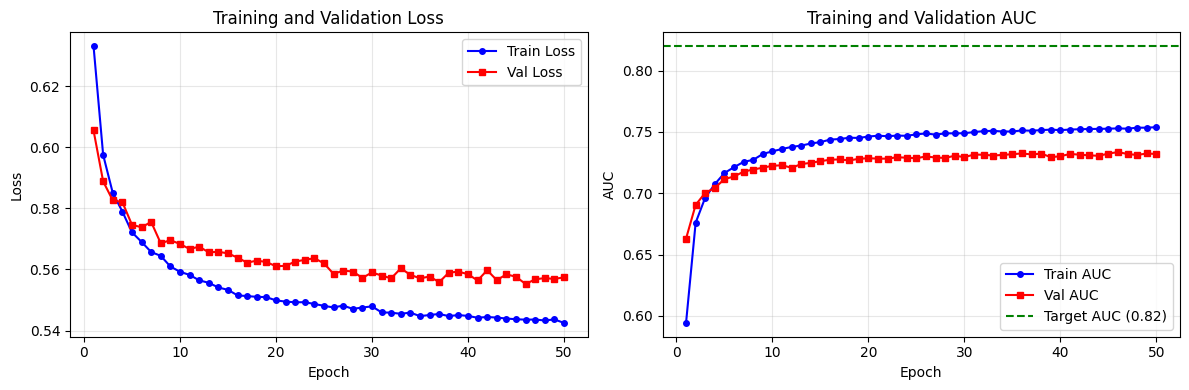

Training Summary:
----------------------------------------
Total epochs trained: 50
Best validation AUC: 0.7336
Final train AUC: 0.7540
Final validation AUC: 0.7320

Train-Val gap: 0.0219
✓ No significant overfitting detected


In [123]:
# CELL 15: Plot Training History

# Create figure with two subplots
plt.figure(figsize=(12, 4))

# Subplot 1: Loss curves
plt.subplot(1, 2, 1)
epochs = range(1, len(history['train_loss']) + 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o', markersize=4)
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss', marker='s', markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: AUC curves
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_auc'], 'b-', label='Train AUC', marker='o', markersize=4)
plt.plot(epochs, history['val_auc'], 'r-', label='Val AUC', marker='s', markersize=4)
plt.axhline(y=0.82, color='g', linestyle='--', label='Target AUC (0.82)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print("-" * 40)
print(f"Total epochs trained: {len(history['train_loss'])}")
print(f"Best validation AUC: {max(history['val_auc']):.4f}")
print(f"Final train AUC: {history['train_auc'][-1]:.4f}")
print(f"Final validation AUC: {history['val_auc'][-1]:.4f}")

# Check for overfitting
final_gap = history['train_auc'][-1] - history['val_auc'][-1]
print(f"\nTrain-Val gap: {final_gap:.4f}")
if final_gap > 0.05:
    print("Model might be overfitting")
else:
    print("✓ No significant overfitting detected")

# CELL 16: Evaluate on Test Set

In [124]:
3# CELL 16: Evaluate on Test Set

# Load best model
checkpoint = torch.load('best_sakt_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with val AUC {checkpoint['best_val_auc']:.4f}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_auc = validate_epoch(model, test_loader, criterion, device)

print(f"\nTest Set Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Compare with validation performance
print(f"\nGeneralization check:")
print(f"Validation AUC: {checkpoint['best_val_auc']:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Val-Test gap: {abs(checkpoint['best_val_auc'] - test_auc):.4f}")

# Additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get predictions for additional metrics
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        interactions = batch['interactions'].to(device)
        skills = batch['skills'].to(device)
        targets = batch['targets'].to(device)
        mask = batch['mask'].to(device)

        predictions = model(interactions, skills)

        valid_idx = mask == 1
        # Only include non-padded predictions
        for i in range(batch_size):
            mask_i = mask[i].cpu().numpy()
            pred_i = predictions[i].cpu().numpy()
            target_i = targets[i].cpu().numpy()

            # Only add non-padded values
            valid_idx = mask_i == 1
            # Only include non-padded predictions
            for i in range(batch_size):
                mask_i = mask[i].cpu().numpy()
                pred_i = predictions[i].cpu().numpy()
                target_i = targets[i].cpu().numpy()

                # Only add non-padded values
                valid_idx = mask_i == 1
                all_predictions.extend(pred_i[valid_idx].tolist())
                all_targets.extend(target_i[valid_idx].tolist())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate additional metrics using 0.5 threshold
binary_predictions = (all_predictions > 0.5).astype(int)

accuracy = accuracy_score(all_targets, binary_predictions)
precision = precision_score(all_targets, binary_predictions)
recall = recall_score(all_targets, binary_predictions)
f1 = f1_score(all_targets, binary_predictions)

print(f"\nAdditional Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Loaded best model from epoch 46 with val AUC 0.7336

Evaluating on test set...



Test Set Results:
Test Loss: 0.5576
Test AUC: 0.7367

Generalization check:
Validation AUC: 0.7336
Test AUC: 0.7367
Val-Test gap: 0.0031


NameError: name 'batch_size' is not defined

# CELL 17: Save Final Model and Results

In [ ]:
# CELL 17: Save Final Model and Results

import json
from datetime import datetime

# Create results summary
results = {
    'model_name': 'SAKT',
    'dataset': 'ASSISTments2009',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'hyperparameters': {
        'num_skills': 145,
        'embed_dim': 128,
        'num_heads': 5,
        'dropout': 0.2,
        'learning_rate': 0.001,
        'batch_size': 64,
        'max_seq_len': 100
    },
    'results': {
        'best_val_auc': float(checkpoint['best_val_auc']),
        'test_auc': float(test_auc),
        'test_accuracy': float(accuracy),
        'test_precision': float(precision),
        'test_recall': float(recall),
        'test_f1': float(f1),
        'total_epochs': len(history['train_loss']),
        'best_epoch': checkpoint['epoch']
    },
    'data_stats': {
        'train_students': len(data['train']),
        'val_students': len(data['val']),
        'test_students': len(data['test']),
        'unique_skills': data['num_skills']
    }
}

# Save results to JSON
with open('sakt_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Save final model with all information
final_save = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results,
    'history': history,
    'skill_to_idx': data['skill_to_idx']
}

torch.save(final_save, 'sakt_final_model.pth')

print("Model and results saved!")
print(f"\nSummary for thesis:")
print(f"- SAKT achieved {test_auc:.4f} AUC on ASSISTments2009")
print(f"- Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"- Training took {len(history['train_loss'])} epochs")

In [ ]:
# CELL: Hyperparameter Search for SAKT

import itertools
from datetime import datetime
import json

# Define hyperparameter search space
param_grid = {
    'embed_dim': [100, 150, 200],  # Paper tested these
    'num_heads': [5],  # Keep at 5 as per paper
    'dropout': [0.1, 0.2, 0.3],
    'lr': [5e-4, 1e-3, 2e-3],
    'weight_decay': [0, 1e-5, 1e-4],
    'batch_size': [64, 128],  # Paper mentions 128 for ASSIST2009
}

# Generate all combinations
param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total hyperparameter combinations to test: {len(param_combinations)}")

# Function to train with specific hyperparameters
def train_with_params(params_dict, max_epochs=20, patience=5):
    """
    Train SAKT with given hyperparameters and return best validation AUC
    """
    # Create model with specified parameters
    model = SAKT(
        num_skills=145,
        embed_dim=params_dict['embed_dim'],
        num_heads=params_dict['num_heads'],
        dropout=params_dict['dropout']
    ).to(device)

    # Create optimizer with specified learning rate
    optimizer = optim.Adam(
        model.parameters(),
        lr=params_dict['lr'],
        weight_decay=params_dict['weight_decay']
    )

    # Recreate data loaders with specified batch size
    train_loader_hp = DataLoader(train_dataset, batch_size=params_dict['batch_size'], shuffle=True)
    val_loader_hp = DataLoader(val_dataset, batch_size=params_dict['batch_size'], shuffle=False)

    # Loss function
    criterion = nn.BCELoss(reduction='none')

    # Training loop with early stopping
    best_val_auc = 0
    patience_counter = 0

    for epoch in range(max_epochs):
        # Train epoch
        train_loss, train_auc = train_epoch(model, train_loader_hp, optimizer, criterion, device)

        # Validate
        val_loss, val_auc = validate_epoch(model, val_loader_hp, criterion, device)

        # Check if improved
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            break

    return best_val_auc, epoch + 1

# Run hyperparameter search
results = []
best_auc = 0
best_params = None

print("\nStarting hyperparameter search...")
print("="*80)

# Test a subset first (remove this limit for full search)
# For full search, remove the [:10] to test all combinations
for i, param_values in enumerate(param_combinations):  # Testing all combinations
    params_dict = dict(zip(param_names, param_values))

    print(f"\nTesting combination {i+1}/{len(param_combinations)}")
    print(f"Parameters: {params_dict}")

    try:
        # Train with these parameters
        val_auc, epochs_trained = train_with_params(params_dict, max_epochs=15, patience=3)

        # Store results
        result = {
            'params': params_dict,
            'val_auc': val_auc,
            'epochs': epochs_trained
        }
        results.append(result)

        print(f"Validation AUC: {val_auc:.4f} (trained for {epochs_trained} epochs)")

        # Track best
        if val_auc > best_auc:
            best_auc = val_auc
            best_params = params_dict
            print(f"✓ New best AUC!")

    except Exception as e:
        print(f"Error with parameters {params_dict}: {str(e)}")
        continue

# Sort results by AUC
results.sort(key=lambda x: x['val_auc'], reverse=True)

print("\n" + "="*80)
print("HYPERPARAMETER SEARCH RESULTS")
print("="*80)
print(f"\nBest parameters found:")
print(f"AUC: {best_auc:.4f}")
for param, value in best_params.items():
    print(f"{param}: {value}")

print("\nTop 5 configurations:")
for i, result in enumerate(results[:5]):
    print(f"\n{i+1}. AUC: {result['val_auc']:.4f}")
    for param, value in result['params'].items():
        print(f"   {param}: {value}")

# Save results
with open('hyperparameter_search_results.json', 'w') as f:
    json.dump(results, f, indent=2)